In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.UCF101(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 101/101 [00:02<00:00, 48.77it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/ucf_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
    'Hand Stand Pushups': 'Handstand_Pushups'
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
    'Archery': ['arrow'],
    'Baby Crawling': ['baby'],
    'Baseball Pitch': ['ball'],
    'Basketball': ['ball'],
    'Basketball Dunk': ['ball'],
    'Billiards': ['ball'],
    'Blowing Candles': ['candle'],
    'Bowling': ['ball'],
    'Cricket Bowling': ['ball'],
    'Cricket Shot': ['ball'],
    'Cutting In Kitchen': ['cut'],
    'Diving': ['dive', 'water'],
    'Drumming': ['drum'],
    'Fencing': ['fencer', 'swordsmanship', 'stick'],
    'Front Crawl': ['swimming'],
    'Haircut': ['hair'],
    'Hammer Throw': ['ball'],
    'Hammering': ['hammer'],
    'Hand Stand Pushups': ['handstand', 'hand'],
    'Horse Riding': ['horseback'],
    'Jumping Jack': ['arm'],
    'Knitting': ['needle'],
    'Lunges': ['lunge', 'lunging'],
    'Mixing': ['mix'],
    'Nunchucks': ['stick'],
    'Pull Ups': ['bar'],
    'Punch': ['punching'],
    'Shaving Beard': ['razor'],
    'Shotput': ['shot'],
    'Skate Boarding': ['skateboard'],
    'Skiing': ['ski'],
    'Skijet': ['jet'],
    'Sky Diving': ['skydive', 'parachute'],
    'Surfing': ['surfboard', 'board'],
    'Typing': ['keyboard'],
    'Uneven Bars': ['bar'],
    'Volleyball Spiking': ['ball'],
}

In [14]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 6 prompts for (0)Apply_Eye_Makeup
["There is no one definitive answer to this question, as people's individual circumstances and preferences will differ.", 'There is no one answer to this question, as everyone has their own unique style.', '1.', '1.', '1.', '1) Place a small amount of foundation on the tip of your finger.']

Filtered 6 prompts for (1)Apply_Lipstick
['There is no one definitive answer to this question.', 'There is no one definitive answer to this question.', '1.', '1.', 'Start with freshly exfoliated and moisturized lips.', 'Start by putting the lip balm on your lips to moisturize them and make them softer.']

Filtered 1 prompts for (3)Baby_Crawling
['Moving about on all fours with the belly off the ground.']

Filtered 2 prompts for (5)Band_Marching
['.', 'Some people might look like they are having a lot of fun, while others may look like they are struggling.']

Filtered 3 prompts for (6)Baseball_Pitch
['When the pitcher winds up, he brings his arm back behind

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 101/101 [00:01<00:00, 84.03it/s]


In [16]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [17]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 101/101 [00:11<00:00,  8.47it/s]


In [18]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [19]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [20]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [21]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 60.96%
Accuracy of CLIP with text template (centroid): 64.87%
Accuracy of CLIP with text template (individual avg): 63.84%
Accuracy of CLIP with original GPT-3 text (centroid): 70.55%
Accuracy of CLIP with original GPT-3 text (individual avg): 69.81%
Accuracy of CLIP with filtered GPT-3 text (centroid): 70.74%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 70.34%
Accuracy of CLIP with combined original GPT-3 text (centroid): 67.25%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 66.83%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 67.46%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 67.04%


In [22]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [23]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=61.58%, std=0.0218861258878335
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=60.33%, std=0.023600355698969143


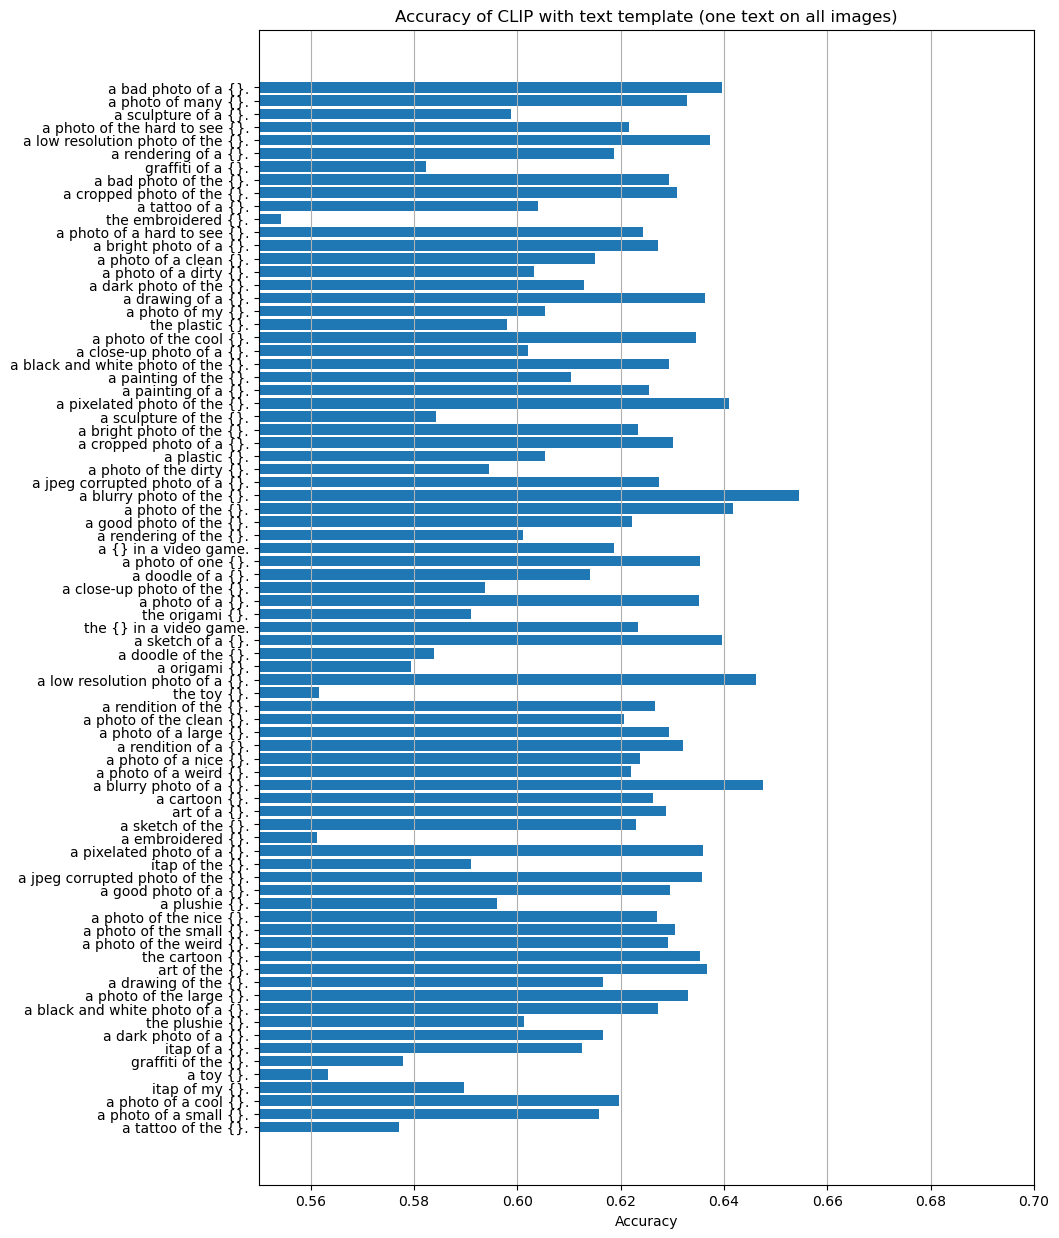

In [24]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [25]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [26]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [27]:
def print_top_pairs(similarity, text, top=10):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [28]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [29]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [30]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [31]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20)
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20)
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.72705078125
Class name similarity std: 0.052642822265625
Rank 1: (7)Basketball - (8)Basketball_Dunk, similarity: 0.94970703125
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.9306640625
Rank 3: (45)Juggling_Balls - (83)Soccer_Juggling, similarity: 0.9296875
Rank 4: (39)High_Jump - (50)Long_Jump, similarity: 0.92822265625
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.92041015625
Rank 6: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.916015625
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.91259765625
Rank 8: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9072265625
Rank 9: (0)Apply_Eye_Makeup - (1)Apply_Lipstick, similarity: 0.90673828125
Rank 10: (15)Bowling - (22)Cricket_Bowling, similarity: 0.90283203125


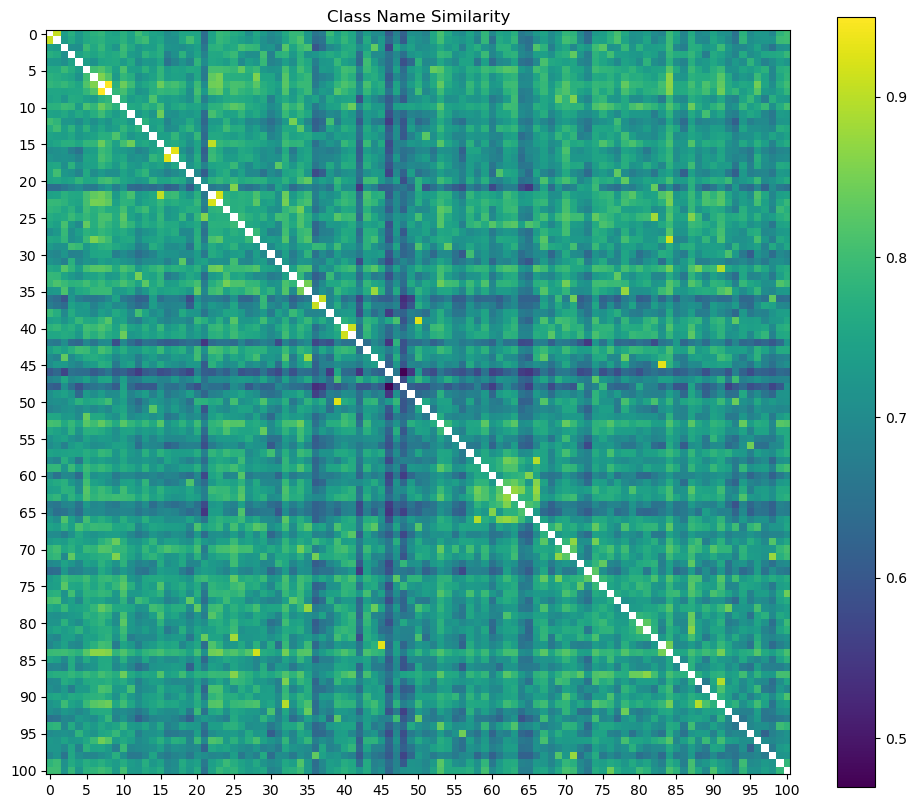

Text template similarity mean: 0.71337890625
Text template similarity std: 0.05523681640625
Rank 1: (39)High_Jump - (50)Long_Jump, similarity: 0.95068359375
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.9501953125
Rank 3: (15)Bowling - (22)Cricket_Bowling, similarity: 0.93408203125
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9267578125
Rank 5: (40)Horse_Race - (41)Horse_Riding, similarity: 0.92431640625
Rank 6: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.92431640625
Rank 7: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.92138671875
Rank 8: (45)Juggling_Balls - (83)Soccer_Juggling, similarity: 0.91552734375
Rank 9: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.90625
Rank 10: (58)Playing_Cello - (66)Playing_Violin, similarity: 0.89892578125


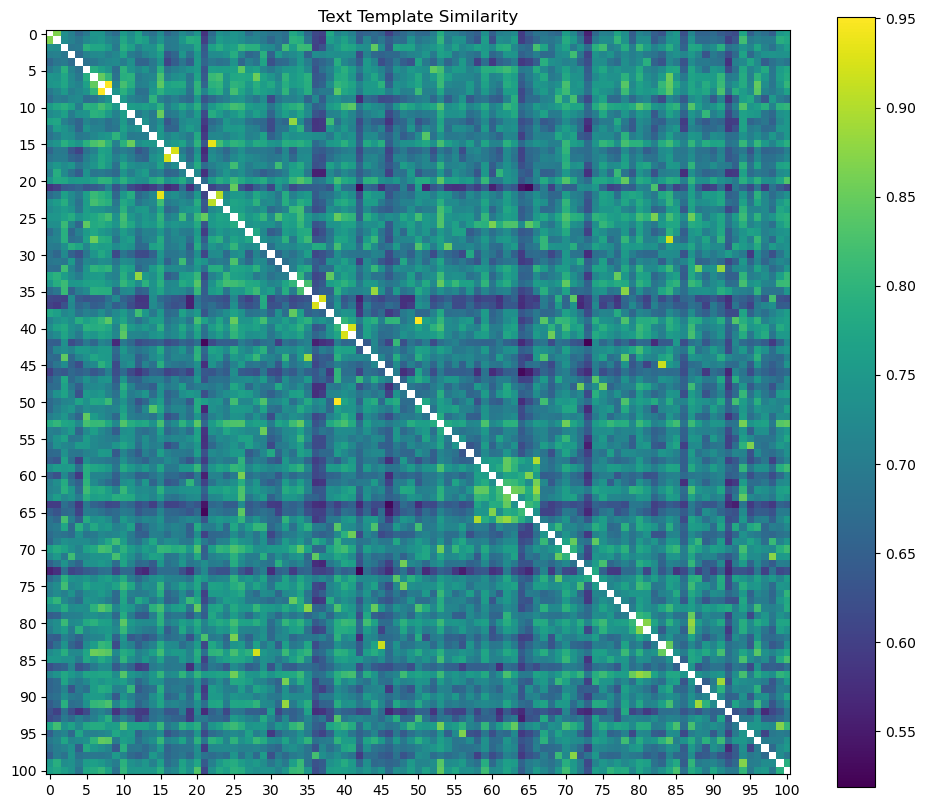

Original gpt-3 text similarity mean: 0.744140625
Original gpt-3 text similarity std: 0.056549072265625
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.96142578125
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.951171875
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9501953125
Rank 5: (39)High_Jump - (50)Long_Jump, similarity: 0.9443359375
Rank 6: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.9404296875
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, similarity: 0.931640625
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.93017578125
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, similarity: 0.9208984375


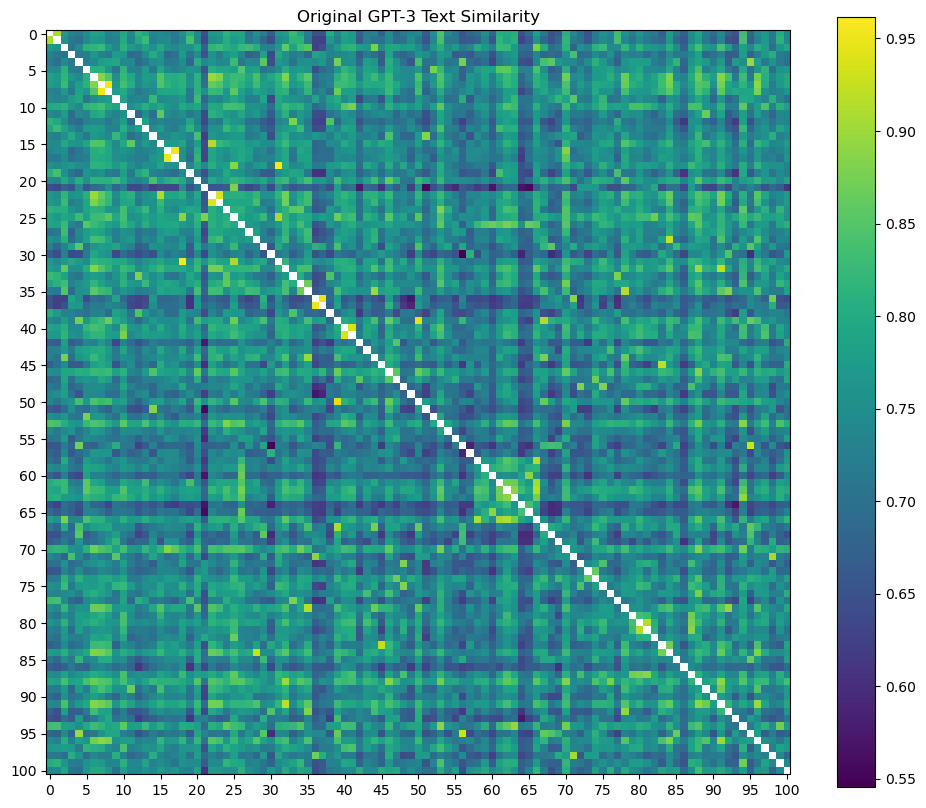

Filtered gpt-3 text similarity mean: 0.73681640625
Filtered gpt-3 text similarity std: 0.05755615234375
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.95947265625
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.94970703125
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.94970703125
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.9404296875
Rank 6: (39)High_Jump - (50)Long_Jump, similarity: 0.939453125
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, similarity: 0.93017578125
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.92431640625
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, similarity: 0.919921875


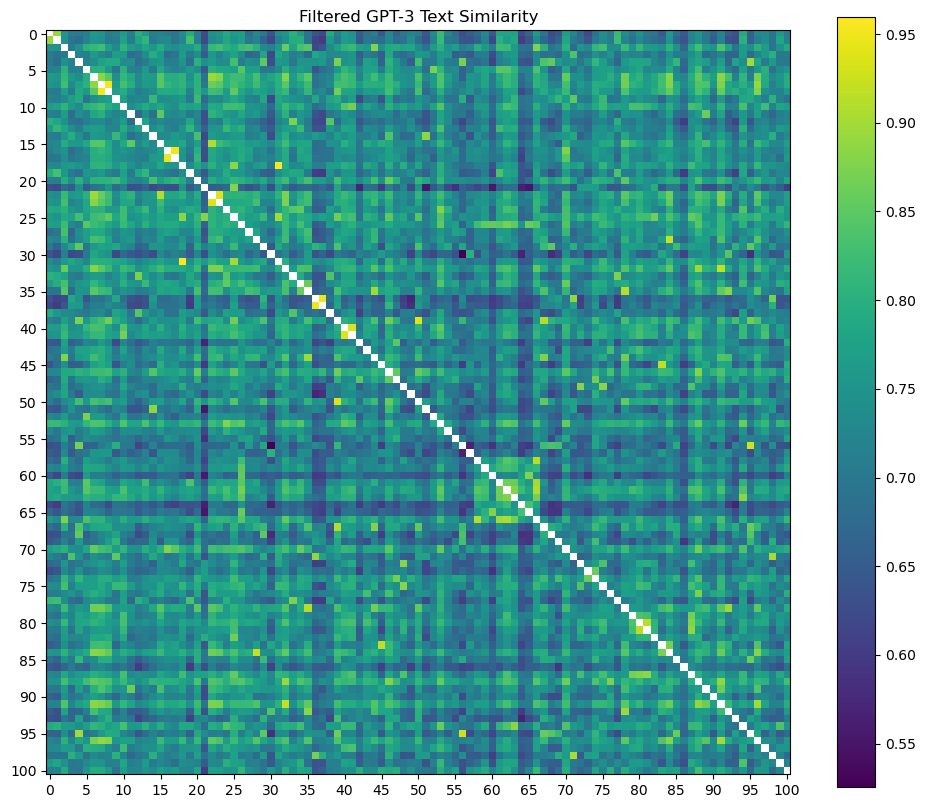

In [32]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.7294921875
Image similarity std: 0.0853271484375
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.97314453125
Rank 2: (39)High_Jump - (44)Javelin_Throw, similarity: 0.9697265625
Rank 3: (4)Balance_Beam - (56)Parallel_Bars, similarity: 0.962890625
Rank 4: (4)Balance_Beam - (29)Floor_Gymnastics, similarity: 0.96240234375
Rank 5: (88)Swing - (93)Trampoline_Jumping, similarity: 0.96044921875
Rank 6: (39)High_Jump - (50)Long_Jump, similarity: 0.958984375
Rank 7: (18)Breast_Stroke - (25)Diving, similarity: 0.95751953125
Rank 8: (78)Shotput - (92)Throw_Discus, similarity: 0.95703125
Rank 9: (12)Blow_Dry_Hair - (33)Haircut, similarity: 0.953125
Rank 10: (44)Javelin_Throw - (50)Long_Jump, similarity: 0.951171875


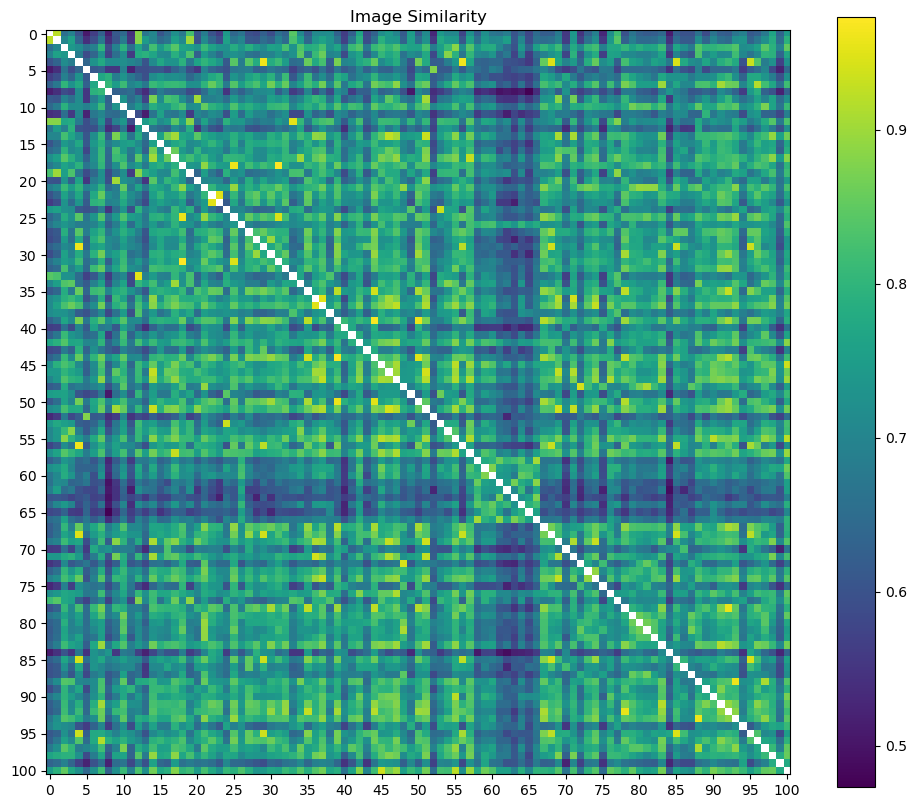

Image to class name similarity mean: 0.208984375
Image to class name similarity std: 0.030303955078125
Image to class name similarity diagonal mean: 0.2939453125
Image to class name similarity diagonal std: 0.0274810791015625
Image to class name similarity non-diagonal mean: 0.2081298828125
Image to class name similarity non-diagonal std: 0.0290985107421875
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.412109375
Rank 1: (92)Throw_Discus - (35)Hammer_Throw, similarity: 0.32470703125
Rank 2: (60)Playing_Dhol - (65)Playing_Tabla, similarity: 0.323974609375
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.3232421875
Rank 4: (35)Hammer_Throw - (44)Javelin_Throw, similarity: 0.322021484375
Rank 5: (78)Shotput - (35)Hammer_Throw, similarity: 0.321533203125
Rank 6: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.3203125
Rank 7: (56)Parallel_Bars - (67)Pole_Vault, similarity: 0.317138671875
Rank 8: (78)Shotput - (44)Javelin_Throw, s

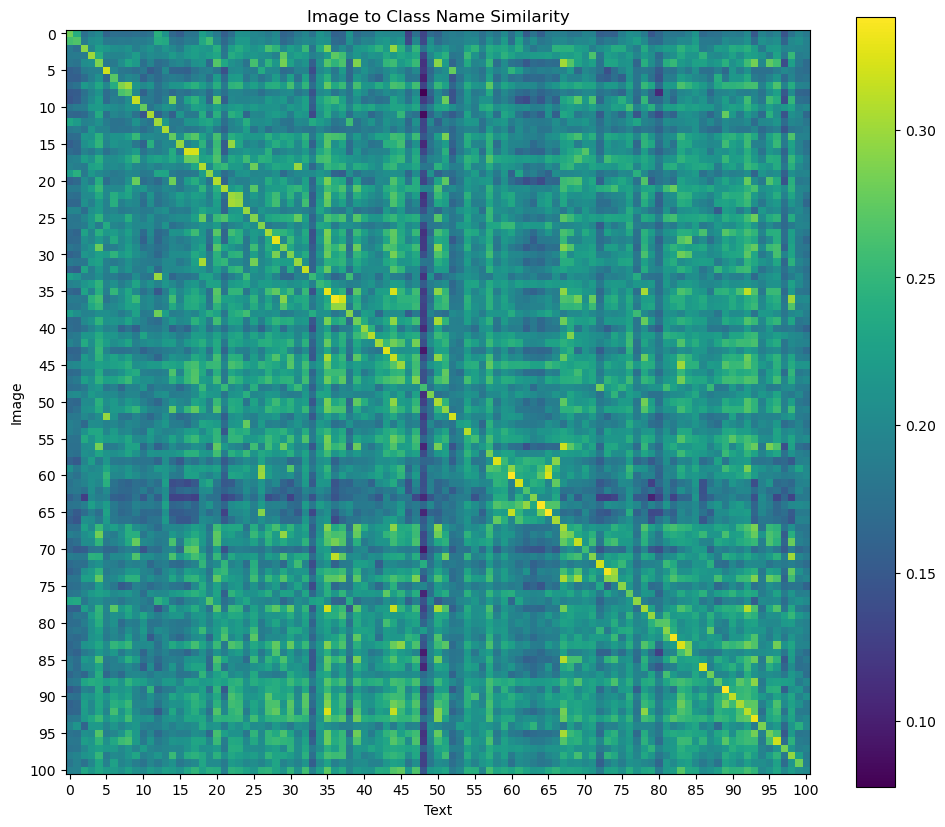

Rank 1: (33)Haircut - (12)Blow_Dry_Hair, error rate: 0.9393939393939394
Rank 2: (53)Mixing - (24)Cutting_In_Kitchen, error rate: 0.9333333333333333
Rank 3: (71)Push_Ups - (36)Handstand_Pushups, error rate: 0.9
Rank 4: (70)Punch - (17)Boxing_Speed_Bag, error rate: 0.8974358974358975
Rank 5: (56)Parallel_Bars - (67)Pole_Vault, error rate: 0.8648648648648649
Rank 6: (7)Basketball - (8)Basketball_Dunk, error rate: 0.8285714285714286
Rank 7: (95)Uneven_Bars - (67)Pole_Vault, error rate: 0.7857142857142857
Rank 8: (31)Front_Crawl - (18)Breast_Stroke, error rate: 0.7567567567567568
Rank 9: (85)Still_Rings - (67)Pole_Vault, error rate: 0.75
Rank 10: (92)Throw_Discus - (35)Hammer_Throw, error rate: 0.7368421052631579
Rank 11: (48)Kayaking - (72)Rafting, error rate: 0.6666666666666666
Rank 12: (39)High_Jump - (50)Long_Jump, error rate: 0.5945945945945946
Rank 13: (88)Swing - (93)Trampoline_Jumping, error rate: 0.5714285714285714
Rank 14: (59)Playing_Daf - (65)Playing_Tabla, error rate: 0.5365853

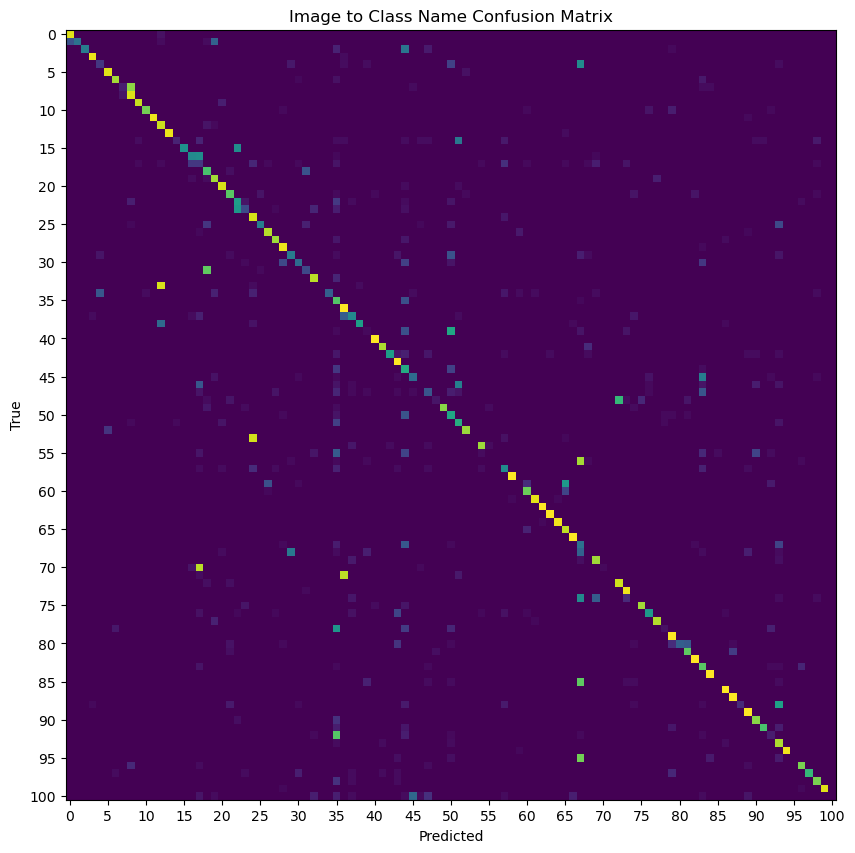

Image to text template (centroid) similarity mean: 0.2000732421875
Image to text template (centroid) similarity std: 0.031585693359375
Image to text template (centroid) similarity diagonal mean: 0.294921875
Image to text template (centroid) similarity diagonal std: 0.02569580078125
Image to text template (centroid) similarity non-diagonal mean: 0.1990966796875
Image to text template (centroid) similarity non-diagonal std: 0.0301666259765625
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.4814453125
Rank 1: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.32763671875
Rank 2: (65)Playing_Tabla - (60)Playing_Dhol, similarity: 0.326904296875
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.32421875
Rank 4: (60)Playing_Dhol - (65)Playing_Tabla, similarity: 0.323974609375
Rank 5: (59)Playing_Daf - (65)Playing_Tabla, similarity: 0.320068359375
Rank 6: (92)Throw_Discus - (35)Hammer_Throw, similarity: 0.319091796875
Rank 

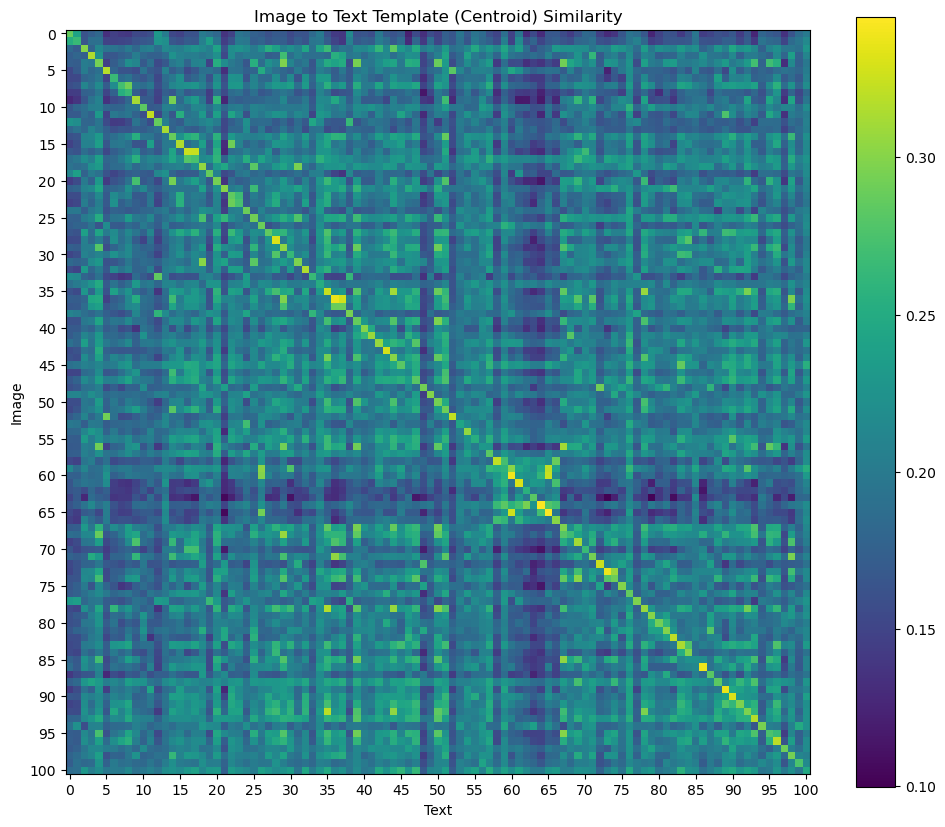

Rank 1: (7)Basketball - (8)Basketball_Dunk, error rate: 0.8857142857142857
Rank 2: (33)Haircut - (12)Blow_Dry_Hair, error rate: 0.8787878787878788
Rank 3: (53)Mixing - (24)Cutting_In_Kitchen, error rate: 0.8444444444444444
Rank 4: (92)Throw_Discus - (35)Hammer_Throw, error rate: 0.7368421052631579
Rank 5: (23)Cricket_Shot - (22)Cricket_Bowling, error rate: 0.7142857142857143
Rank 6: (39)High_Jump - (50)Long_Jump, error rate: 0.7027027027027027
Rank 7: (56)Parallel_Bars - (67)Pole_Vault, error rate: 0.6756756756756757
Rank 8: (31)Front_Crawl - (18)Breast_Stroke, error rate: 0.6216216216216216
Rank 9: (71)Push_Ups - (36)Handstand_Pushups, error rate: 0.5666666666666667
Rank 10: (30)Frisbee_Catch - (28)Field_Hockey_Penalty, error rate: 0.5405405405405406
Rank 11: (59)Playing_Daf - (65)Playing_Tabla, error rate: 0.5365853658536586
Rank 12: (85)Still_Rings - (67)Pole_Vault, error rate: 0.53125
Rank 13: (68)Pommel_Horse - (29)Floor_Gymnastics, error rate: 0.5142857142857142
Rank 14: (48)Kaya

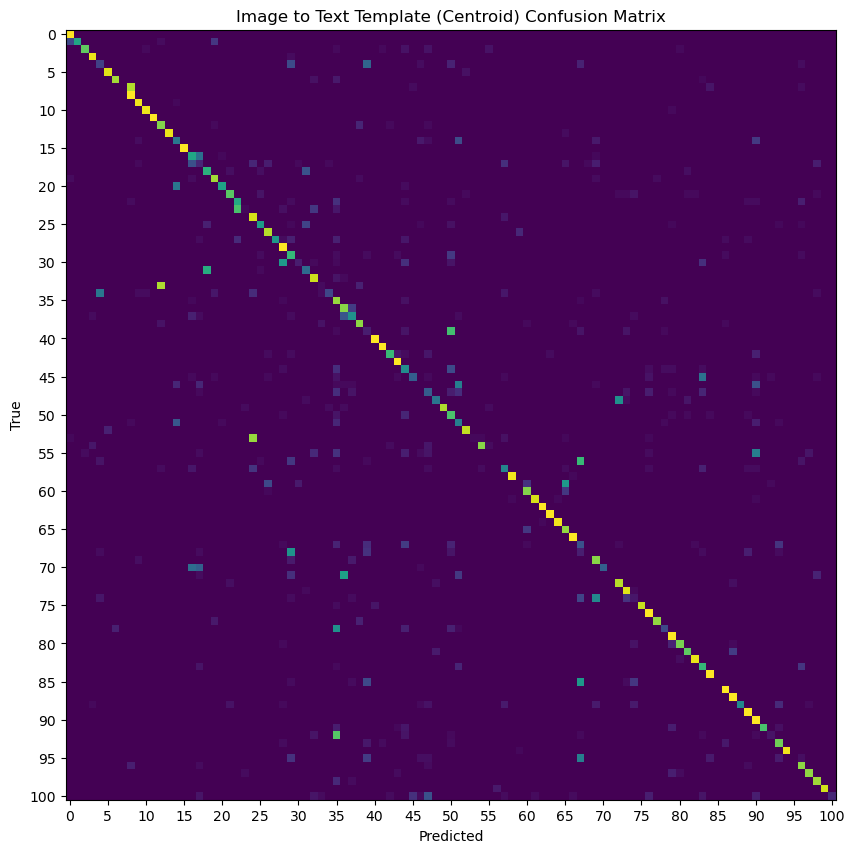

Image to text template (individual avg) similarity mean: 0.1843232363462448
Image to text template (individual avg) similarity std: 0.029197297990322113
Image to text template (individual avg) similarity diagonal mean: 0.27166566252708435
Image to text template (individual avg) similarity diagonal std: 0.02410566620528698
Image to text template (individual avg) similarity non-diagonal mean: 0.18344980478286743
Image to text template (individual avg) similarity non-diagonal std: 0.02789527364075184
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.4808719158172607
Rank 1: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.303955078125
Rank 2: (65)Playing_Tabla - (60)Playing_Dhol, similarity: 0.301025390625
Rank 3: (60)Playing_Dhol - (65)Playing_Tabla, similarity: 0.299072265625
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.299072265625
Rank 5: (59)Playing_Daf - (65)Playing_Tabla, similarity: 0.29541015625
Ran

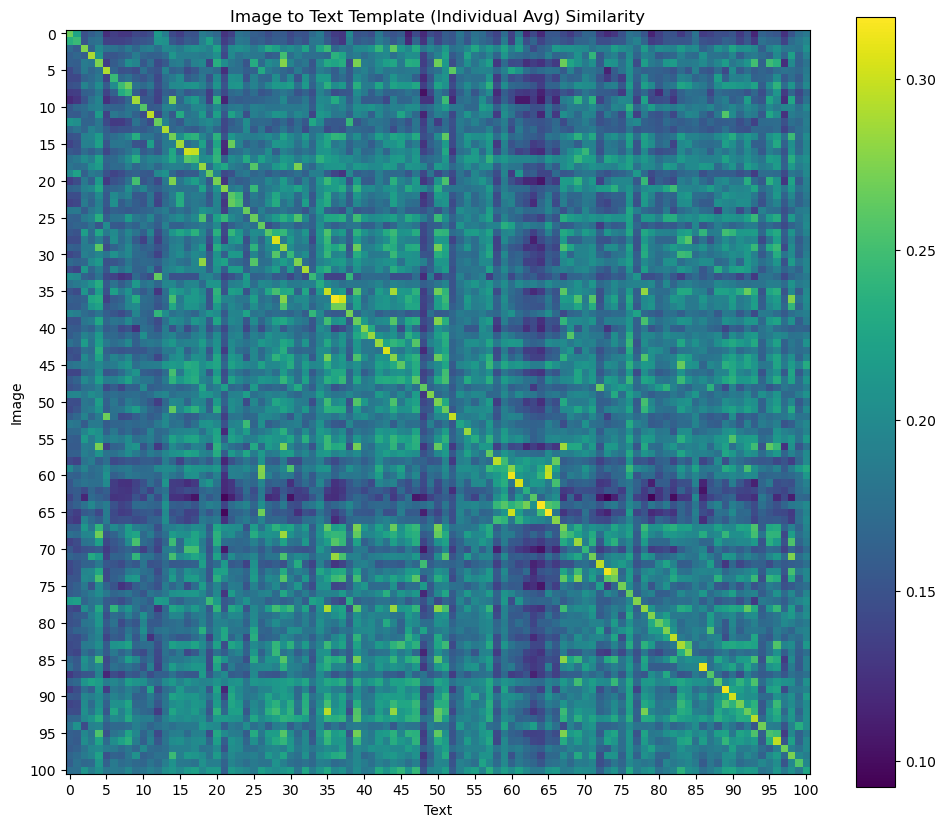

Rank 1: (7)Basketball - (8)Basketball_Dunk, error rate: 0.8857142857142857
Rank 2: (33)Haircut - (12)Blow_Dry_Hair, error rate: 0.8484848484848485
Rank 3: (53)Mixing - (24)Cutting_In_Kitchen, error rate: 0.8
Rank 4: (92)Throw_Discus - (35)Hammer_Throw, error rate: 0.7631578947368421
Rank 5: (39)High_Jump - (50)Long_Jump, error rate: 0.7567567567567568
Rank 6: (31)Front_Crawl - (18)Breast_Stroke, error rate: 0.7027027027027027
Rank 7: (71)Push_Ups - (36)Handstand_Pushups, error rate: 0.7
Rank 8: (23)Cricket_Shot - (22)Cricket_Bowling, error rate: 0.6938775510204082
Rank 9: (56)Parallel_Bars - (67)Pole_Vault, error rate: 0.5945945945945946
Rank 10: (59)Playing_Daf - (65)Playing_Tabla, error rate: 0.5853658536585366
Rank 11: (48)Kayaking - (72)Rafting, error rate: 0.5555555555555556
Rank 12: (30)Frisbee_Catch - (28)Field_Hockey_Penalty, error rate: 0.5405405405405406
Rank 13: (70)Punch - (16)Boxing_Punching_Bag, error rate: 0.5384615384615384
Rank 14: (85)Still_Rings - (67)Pole_Vault, err

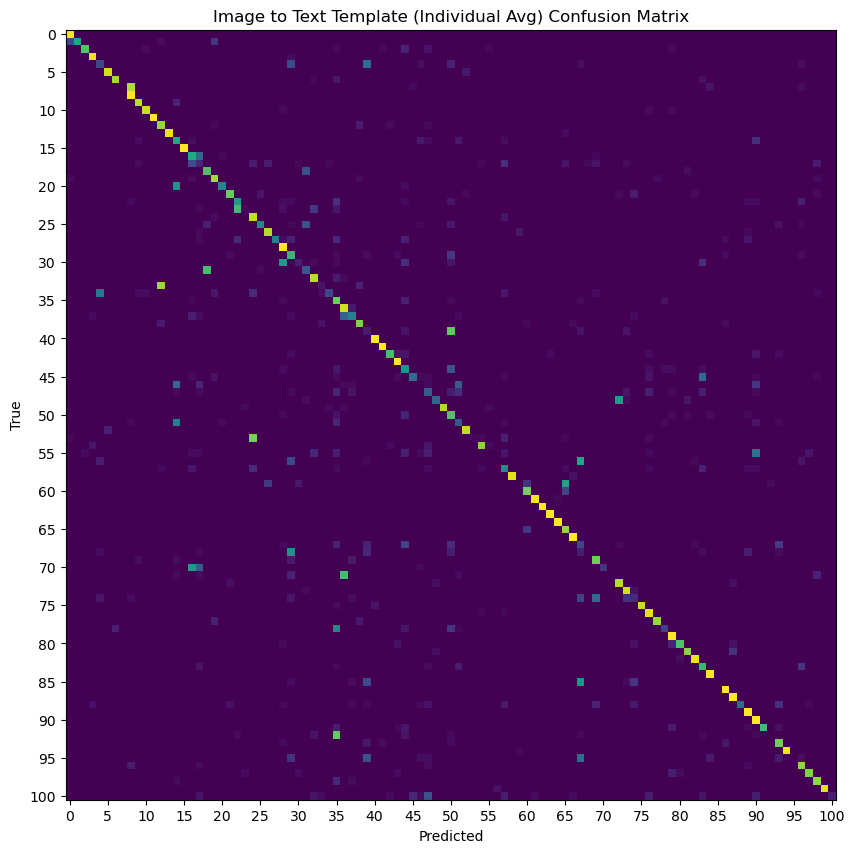

Image to original gpt-3 text (centroid) similarity mean: 0.2032470703125
Image to original gpt-3 text (centroid) similarity std: 0.032501220703125
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.30517578125
Image to original gpt-3 text (centroid) similarity diagonal std: 0.0189971923828125
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.2021484375
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.0309295654296875
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.509765625
Rank 1: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.33154296875
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.328857421875
Rank 3: (35)Hammer_Throw - (92)Throw_Discus, similarity: 0.32568359375
Rank 4: (65)Playing_Tabla - (60)Playing_Dhol, similarity: 0.32421875
Rank 5: (92)Throw_Discus - (35)Hammer_Throw, similarity: 0.320556640625
Rank 6: (71)Push_Ups - (98)Wall_Pushu

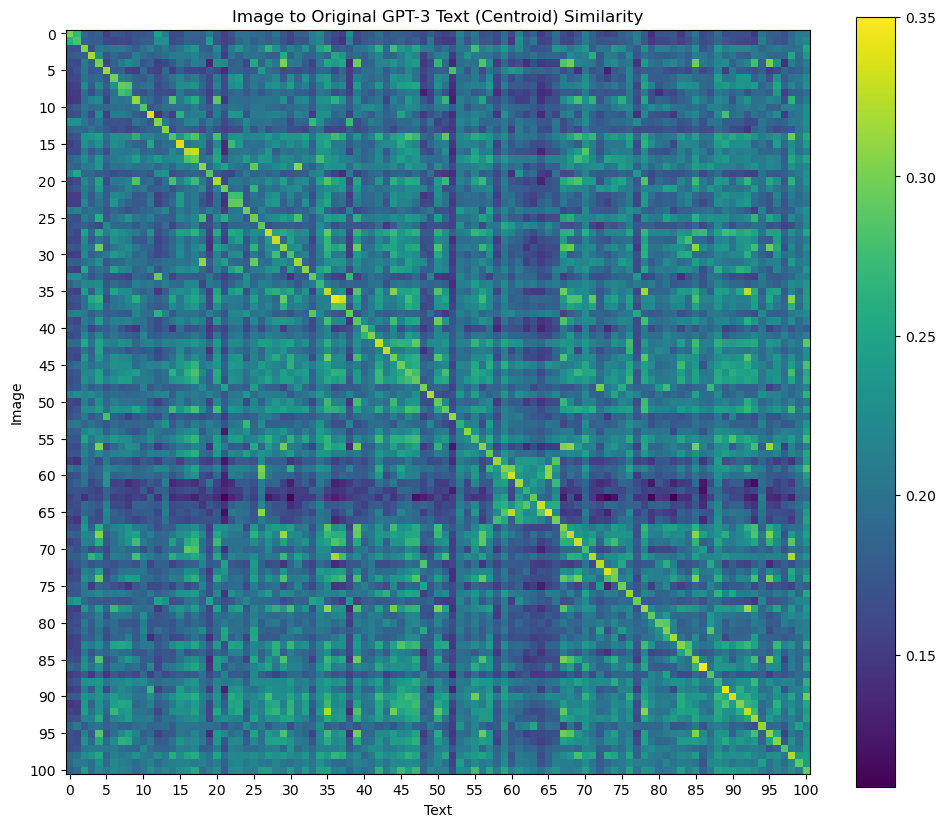

Rank 1: (8)Basketball_Dunk - (7)Basketball, error rate: 0.8918918918918919
Rank 2: (70)Punch - (16)Boxing_Punching_Bag, error rate: 0.8205128205128205
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, error rate: 0.6326530612244898
Rank 4: (53)Mixing - (24)Cutting_In_Kitchen, error rate: 0.6222222222222222
Rank 5: (35)Hammer_Throw - (92)Throw_Discus, error rate: 0.5555555555555556
Rank 6: (39)High_Jump - (50)Long_Jump, error rate: 0.5405405405405406
Rank 7: (18)Breast_Stroke - (31)Front_Crawl, error rate: 0.5357142857142857
Rank 8: (78)Shotput - (92)Throw_Discus, error rate: 0.4782608695652174
Rank 9: (48)Kayaking - (72)Rafting, error rate: 0.4444444444444444
Rank 10: (37)Handstand_Walking - (36)Handstand_Pushups, error rate: 0.4117647058823529
Rank 11: (23)Cricket_Shot - (22)Cricket_Bowling, error rate: 0.40816326530612246
Rank 12: (33)Haircut - (12)Blow_Dry_Hair, error rate: 0.3939393939393939
Rank 13: (59)Playing_Daf - (65)Playing_Tabla, error rate: 0.36585365853658536
Rank 14

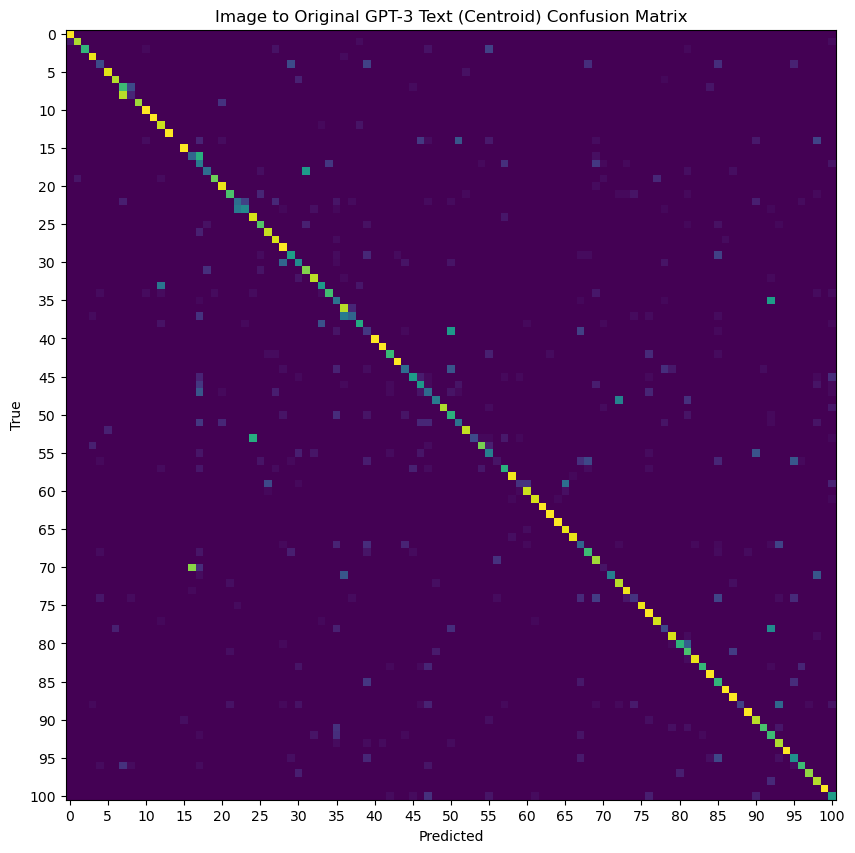

Image to original gpt-3 text (individual avg) similarity mean: 0.1909959316253662
Image to original gpt-3 text (individual avg) similarity std: 0.030202943831682205
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.2868615984916687
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.01875114068388939
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.19003728032112122
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.028722859919071198
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5095016956329346
Rank 1: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.31591796875
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.306640625
Rank 3: (35)Hammer_Throw - (92)Throw_Discus, similarity: 0.303955078125
Rank 4: (92)Throw_Discus - (35)Hammer_Throw, similarity: 0.30224609375
Rank 5: (68)Pommel_Horse - (29)Floor_Gy

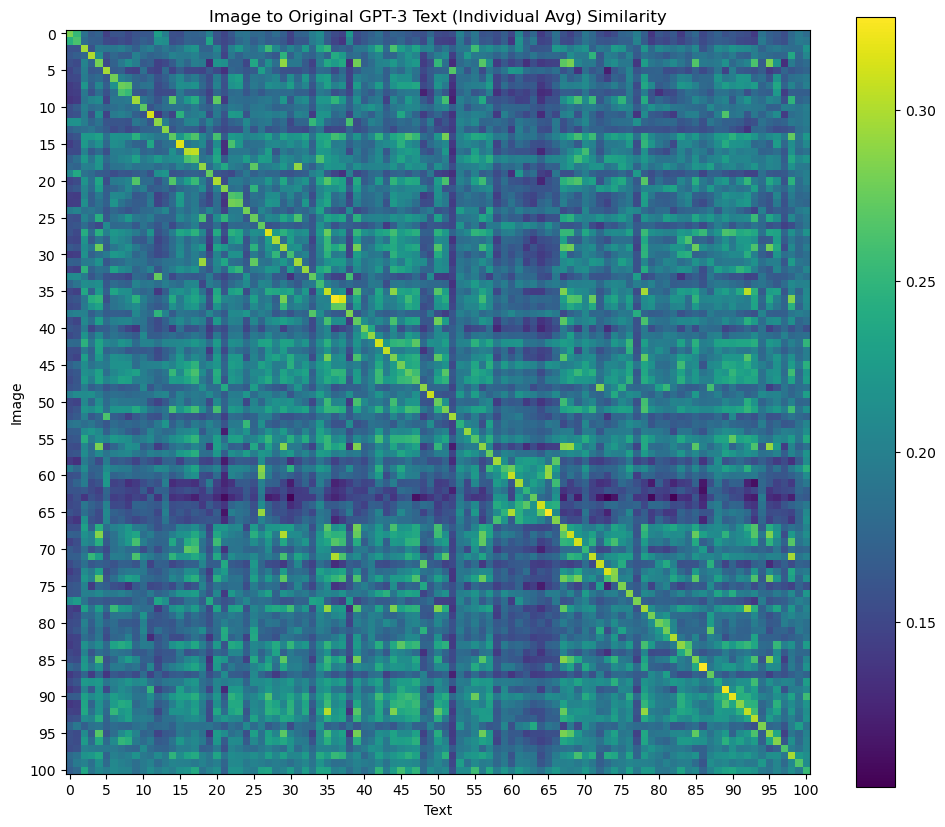

Rank 1: (8)Basketball_Dunk - (7)Basketball, error rate: 0.918918918918919
Rank 2: (70)Punch - (16)Boxing_Punching_Bag, error rate: 0.8717948717948718
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, error rate: 0.6326530612244898
Rank 4: (53)Mixing - (24)Cutting_In_Kitchen, error rate: 0.6222222222222222
Rank 5: (23)Cricket_Shot - (22)Cricket_Bowling, error rate: 0.5306122448979592
Rank 6: (4)Balance_Beam - (29)Floor_Gymnastics, error rate: 0.5161290322580645
Rank 7: (88)Swing - (93)Trampoline_Jumping, error rate: 0.5
Rank 8: (39)High_Jump - (50)Long_Jump, error rate: 0.4594594594594595
Rank 9: (59)Playing_Daf - (65)Playing_Tabla, error rate: 0.43902439024390244
Rank 10: (14)Body_Weight_Squats - (51)Lunges, error rate: 0.43333333333333335
Rank 11: (48)Kayaking - (72)Rafting, error rate: 0.4166666666666667
Rank 12: (78)Shotput - (92)Throw_Discus, error rate: 0.41304347826086957
Rank 13: (55)Nunchucks - (90)Tai_Chi, error rate: 0.4
Rank 14: (33)Haircut - (12)Blow_Dry_Hair, error r

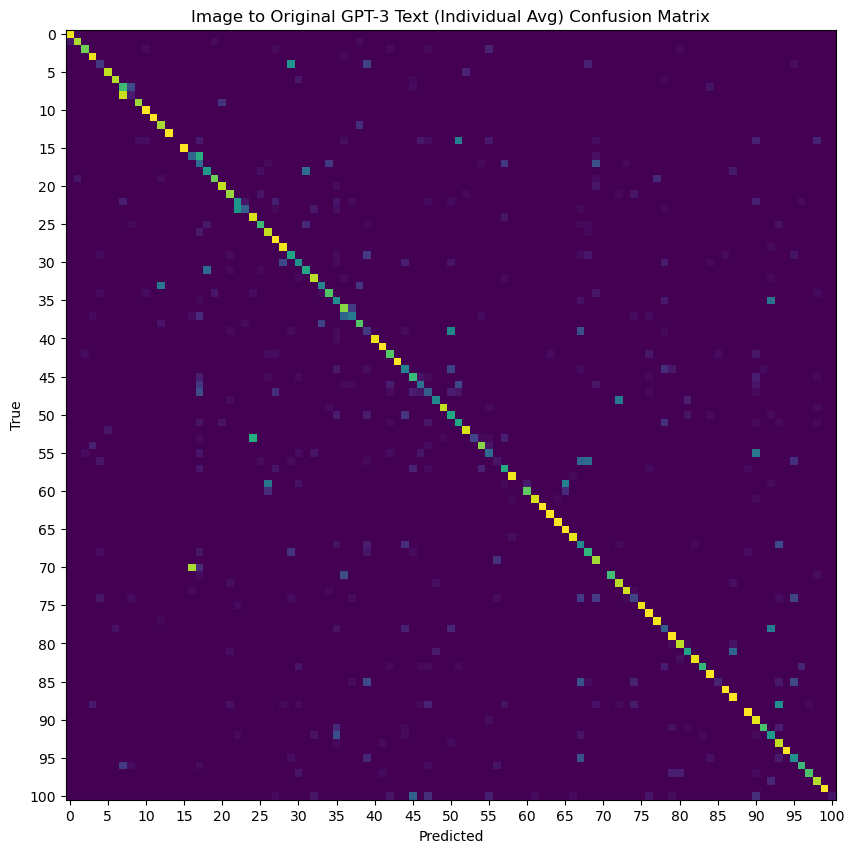

Image to filtered gpt-3 text (centroid) similarity mean: 0.2021484375
Image to filtered gpt-3 text (centroid) similarity std: 0.032867431640625
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.305419921875
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.018951416015625
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.2010498046875
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.031280517578125
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.51953125
Rank 1: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.33154296875
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.3291015625
Rank 3: (35)Hammer_Throw - (92)Throw_Discus, similarity: 0.32568359375
Rank 4: (65)Playing_Tabla - (60)Playing_Dhol, similarity: 0.323486328125
Rank 5: (92)Throw_Discus - (35)Hammer_Throw, similarity: 0.32177734375
Rank 6: (71)Push_Ups - (98)Wall_Pushup

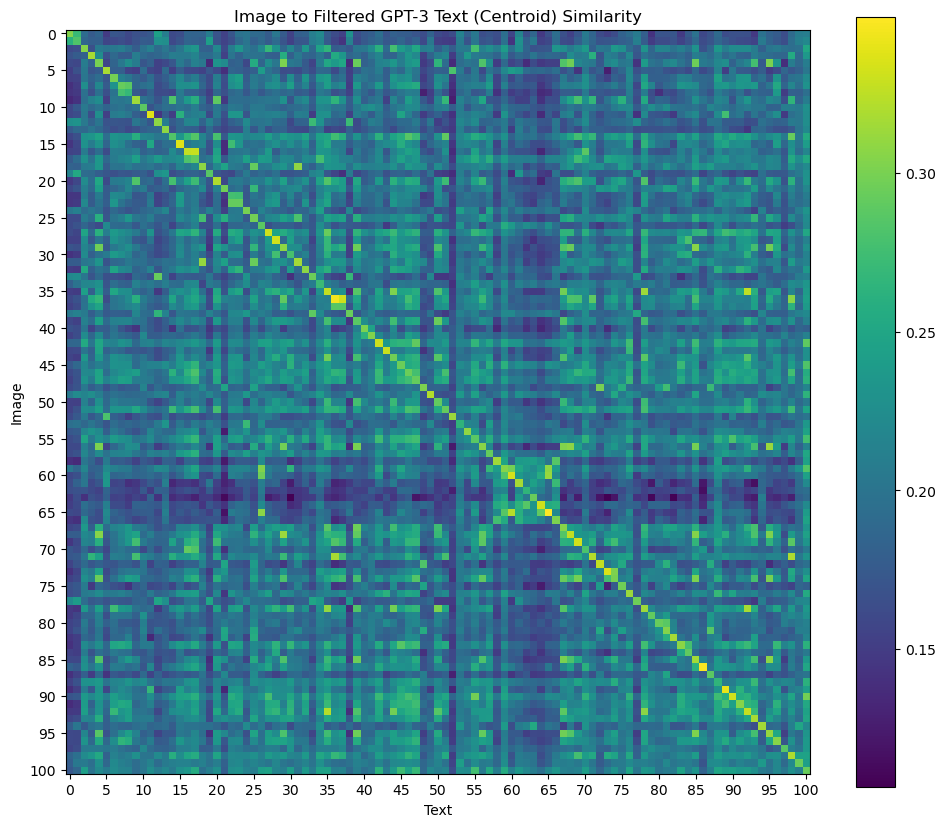

Rank 1: (8)Basketball_Dunk - (7)Basketball, error rate: 0.8918918918918919
Rank 2: (70)Punch - (16)Boxing_Punching_Bag, error rate: 0.8205128205128205
Rank 3: (18)Breast_Stroke - (31)Front_Crawl, error rate: 0.6428571428571429
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, error rate: 0.6122448979591837
Rank 5: (53)Mixing - (24)Cutting_In_Kitchen, error rate: 0.6
Rank 6: (39)High_Jump - (50)Long_Jump, error rate: 0.5135135135135135
Rank 7: (35)Hammer_Throw - (92)Throw_Discus, error rate: 0.4888888888888889
Rank 8: (78)Shotput - (92)Throw_Discus, error rate: 0.45652173913043476
Rank 9: (48)Kayaking - (72)Rafting, error rate: 0.4444444444444444
Rank 10: (37)Handstand_Walking - (36)Handstand_Pushups, error rate: 0.4117647058823529
Rank 11: (23)Cricket_Shot - (22)Cricket_Bowling, error rate: 0.40816326530612246
Rank 12: (33)Haircut - (12)Blow_Dry_Hair, error rate: 0.3939393939393939
Rank 13: (59)Playing_Daf - (65)Playing_Tabla, error rate: 0.36585365853658536
Rank 14: (88)Swing - 

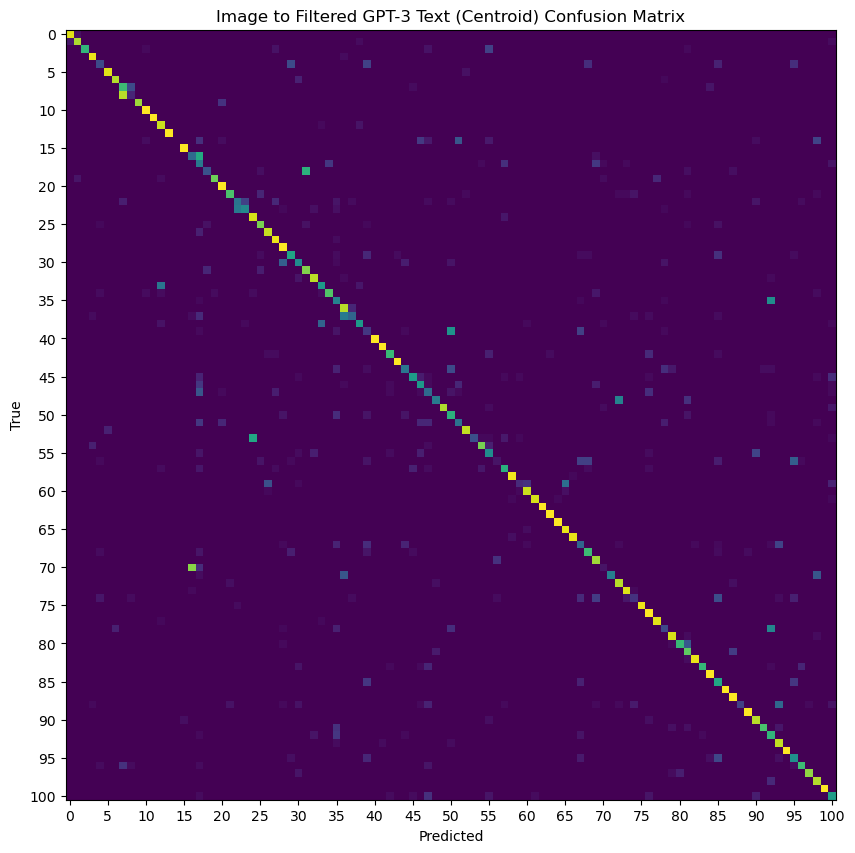

Image to filtered gpt-3 text (individual avg) similarity mean: 0.19091051816940308
Image to filtered gpt-3 text (individual avg) similarity std: 0.03062259964644909
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.2885935604572296
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.018591344356536865
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.18993370234966278
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.029108259826898575
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5194436311721802
Rank 1: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.3173828125
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.30810546875
Rank 3: (92)Throw_Discus - (35)Hammer_Throw, similarity: 0.305908203125
Rank 4: (65)Playing_Tabla - (60)Playing_Dhol, similarity: 0.304443359375
Rank 5: (35)Hammer_Throw - (92)Thro

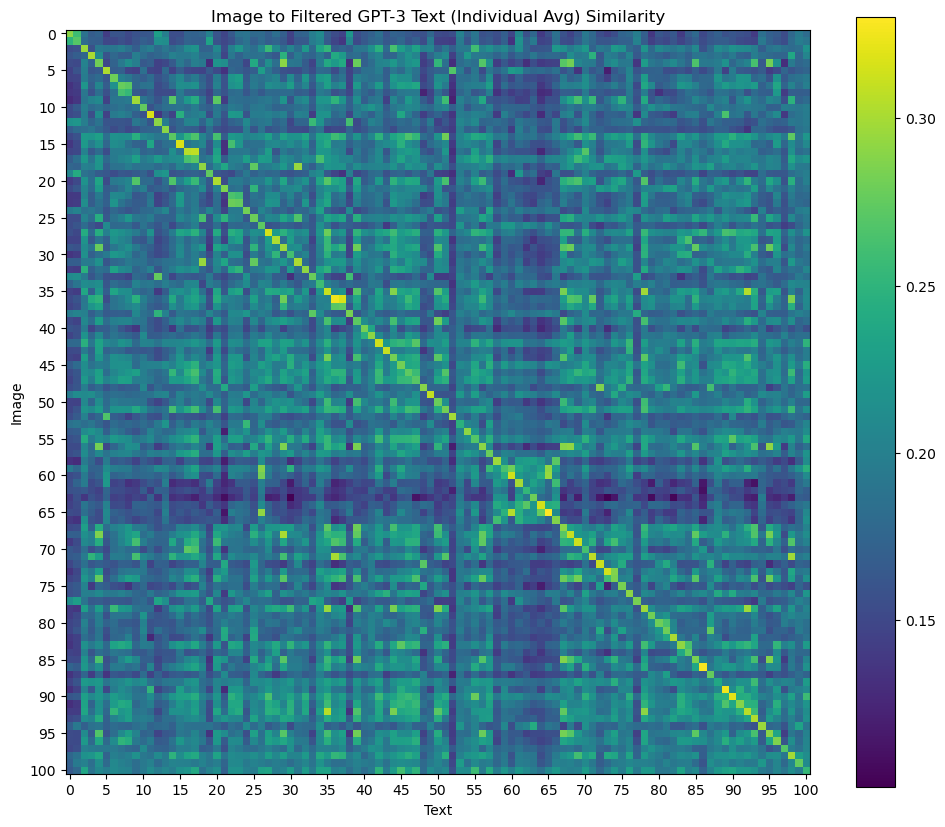

Rank 1: (8)Basketball_Dunk - (7)Basketball, error rate: 0.918918918918919
Rank 2: (70)Punch - (16)Boxing_Punching_Bag, error rate: 0.8461538461538461
Rank 3: (18)Breast_Stroke - (31)Front_Crawl, error rate: 0.7857142857142857
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, error rate: 0.5918367346938775
Rank 5: (4)Balance_Beam - (29)Floor_Gymnastics, error rate: 0.5806451612903226
Rank 6: (53)Mixing - (24)Cutting_In_Kitchen, error rate: 0.5777777777777777
Rank 7: (39)High_Jump - (50)Long_Jump, error rate: 0.5405405405405406
Rank 8: (23)Cricket_Shot - (22)Cricket_Bowling, error rate: 0.5306122448979592
Rank 9: (88)Swing - (93)Trampoline_Jumping, error rate: 0.5
Rank 10: (48)Kayaking - (72)Rafting, error rate: 0.4444444444444444
Rank 11: (59)Playing_Daf - (65)Playing_Tabla, error rate: 0.43902439024390244
Rank 12: (14)Body_Weight_Squats - (51)Lunges, error rate: 0.43333333333333335
Rank 13: (55)Nunchucks - (90)Tai_Chi, error rate: 0.42857142857142855
Rank 14: (92)Throw_Discus - (

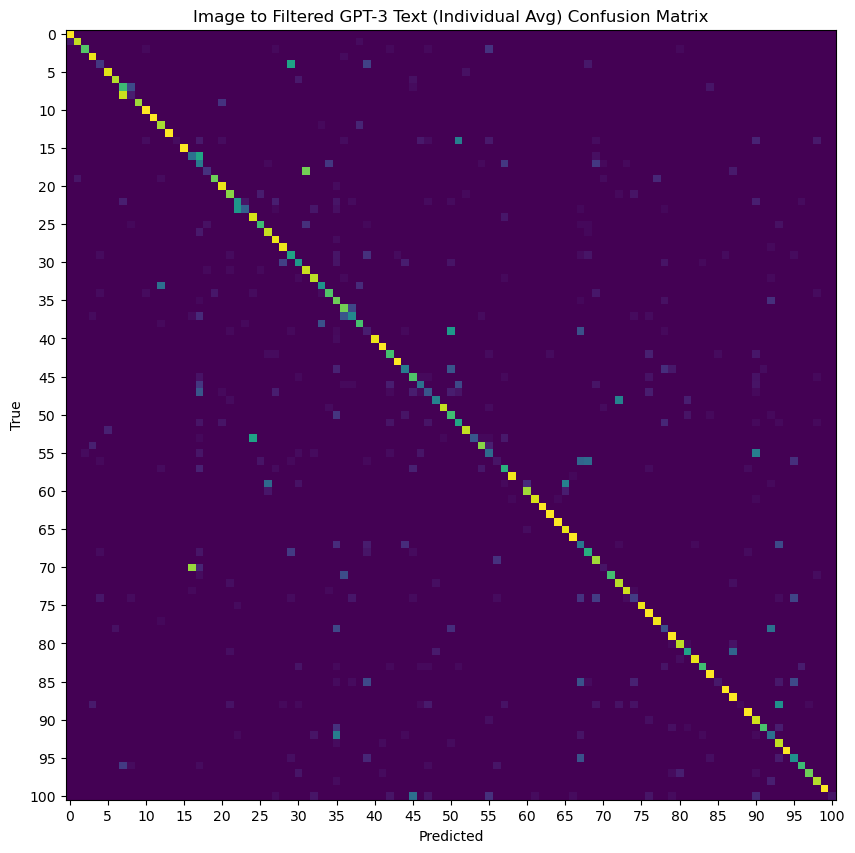

In [33]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [34]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [35]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [36]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (7)Basketball - (8)Basketball_Dunk, similarity: 0.94970703125
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.9306640625
Rank 3: (45)Juggling_Balls - (83)Soccer_Juggling, similarity: 0.9296875
Rank 4: (39)High_Jump - (50)Long_Jump, similarity: 0.92822265625
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.92041015625
Rank 6: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.916015625
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.91259765625
Rank 8: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9072265625
Rank 9: (0)Apply_Eye_Makeup - (1)Apply_Lipstick, similarity: 0.90673828125
Rank 10: (15)Bowling - (22)Cricket_Bowling, similarity: 0.90283203125


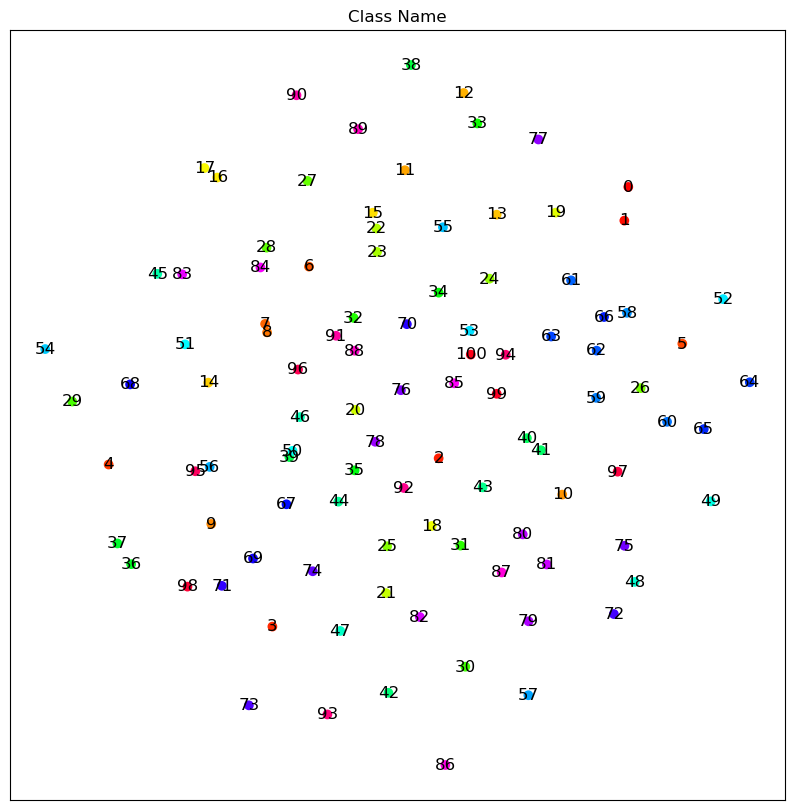

Rank 1: (39)High_Jump - (50)Long_Jump, similarity: 0.95068359375
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.9501953125
Rank 3: (15)Bowling - (22)Cricket_Bowling, similarity: 0.93408203125
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9267578125
Rank 5: (40)Horse_Race - (41)Horse_Riding, similarity: 0.92431640625
Rank 6: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.92431640625
Rank 7: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.92138671875
Rank 8: (45)Juggling_Balls - (83)Soccer_Juggling, similarity: 0.91552734375
Rank 9: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.90625
Rank 10: (58)Playing_Cello - (66)Playing_Violin, similarity: 0.89892578125


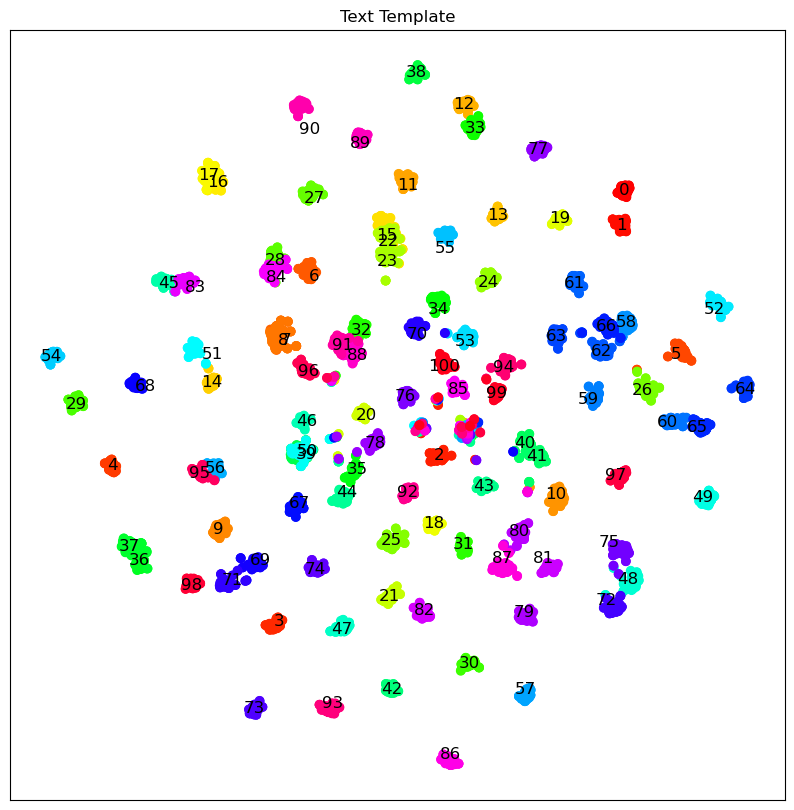

Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.96142578125
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.951171875
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9501953125
Rank 5: (39)High_Jump - (50)Long_Jump, similarity: 0.9443359375
Rank 6: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.9404296875
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, similarity: 0.931640625
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.93017578125
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, similarity: 0.9208984375


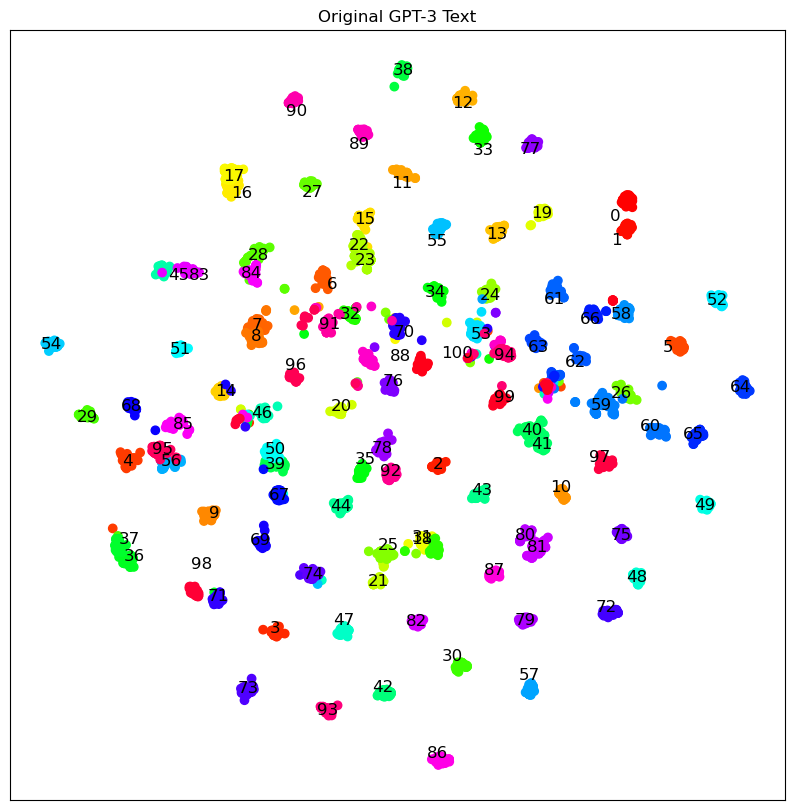

Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.95947265625
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.94970703125
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.94970703125
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.9404296875
Rank 6: (39)High_Jump - (50)Long_Jump, similarity: 0.939453125
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, similarity: 0.93017578125
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.92431640625
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, similarity: 0.919921875


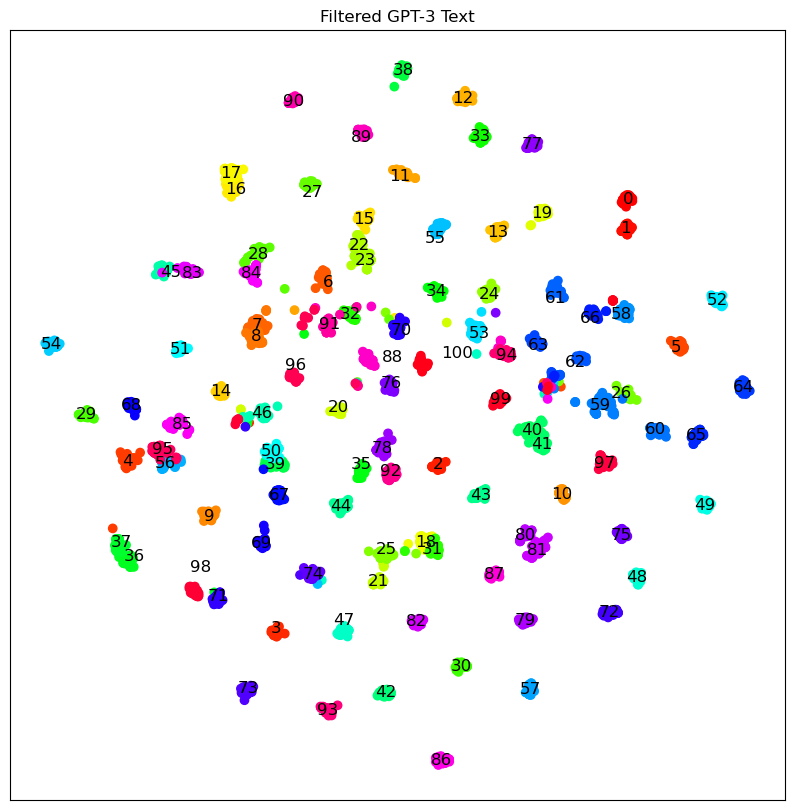

In [37]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')